In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Verbosity is now 5

tf.autograph.set_verbosity(0)


In [4]:
!nvidia-smi

Fri Sep 17 14:23:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Read data

In [5]:
data=pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### There are no null values

### Unique labels

In [7]:
np.unique(data.Score,return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 52268,  29769,  42640,  80655, 363122]))

In [8]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
data.shape

(568454, 10)

### We are doing sentiment analysis hence we will convert label to 0 or 1
### 0: Negative Review
### 1: Positive Review

In [10]:
data.loc[data['Score'] <=2, 'Score'] = 0
data.loc[data['Score'] > 3, 'Score'] = 1

### Dropping Score=3 as it is neutral value

In [11]:
data.drop(data[data['Score']==3].index,inplace=True)

In [12]:
data['len'] = data.Text.apply(lambda x: len(x.split()))

### We are considering first 50 words only 

In [13]:
data = data[data.len<50]

If you want to take fix data, then use below line

In [14]:
data = data.sample(n=50000, random_state=30)

In [15]:
import re

### Removing html tags

In [16]:
data['Text']=data['Text'].apply(lambda row : re.sub('<.*?>','',row))

In [17]:
from sklearn.model_selection import train_test_split

Splitting of data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data[['Text','len']],data.Score, test_size=0.2, random_state=42, stratify=data.Score)

In [19]:
X_train.shape,X_test.shape

((40000, 2), (10000, 2))

we are importing bert layer from tensorflow hub and creating a model with pooled output only so it will take less time to train

In [20]:
max_seq_length = 55
tf.keras.backend.clear_session()
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
                # ids of words
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
                # masking of ids
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
                # segment of ids
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

2021-09-17 14:24:01.922189: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 14:24:01.925466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-17 14:24:01.974608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 14:24:01.975215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-17 14:24:01.975267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-17 14:24:02.000596: I tensorflow/stream_executor/platform/def

In [21]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [22]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [23]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [24]:
import tokenization

In [25]:
def bert_preprocess(sentence,tokenizer,max_seq_len=512):
    tokens=[]
    masks=[]
    segments=[]
    for word in sentence:
        word=tokenizer.tokenize(word)
        word=word[:max_seq_len-2]
        seq=["[CLS]"] + word + ["[SEP]"]
        token = tokenizer.convert_tokens_to_ids(seq)
        padding_tokens=token+[0]*(max_seq_len-len(token))
        mask=[1]*len(seq)
        masking=mask+[0]*(max_seq_len-len(token))
        segment=np.zeros(max_seq_length)
        
        tokens.append(padding_tokens)
        masks.append(masking)
        segments.append(segment)
    return np.array(tokens),np.array(masks),np.array(segments)

In [26]:
tokenizer =tokenization.FullTokenizer(vocab_file,do_lower_case)

In [27]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [28]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [29]:
X_train_tokens, X_train_mask, X_train_segment=bert_preprocess(X_train.Text.values,tokenizer,55)
X_test_tokens, X_test_mask, X_test_segment=bert_preprocess(X_test.Text.values,tokenizer,55)

In [30]:
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

2021-09-17 14:24:48.939956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-17 14:24:48.949605: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz
2021-09-17 14:24:50.512014: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-17 14:24:51.263716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


In [31]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

In [32]:
import datetime
from sklearn.metrics import roc_auc_score

In [33]:
auc=[]
val_auc=[]
class LossHistory(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.history={'val_accuracy': []}


    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        auc_tr=(roc_auc_score(y_train,(self.model.predict(X_train_pooled_output))) )
        auc_test=(roc_auc_score (y_test, (self.model.predict(X_test_pooled_output) ) ) )
        print('\n  train_auc : ',auc_tr)
        print('  val_auc : ',auc_test)
        auc.append(auc_tr)
        val_auc.append(auc_test)
        loss=logs.get('loss')


In [34]:
#Callbacks
filepath="model1_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

history_own = LossHistory()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1)

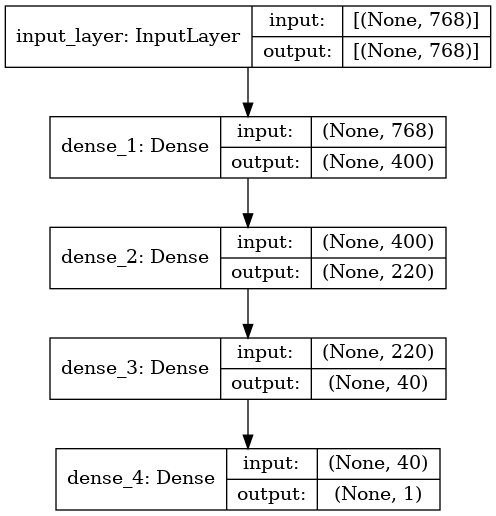

In [35]:
##create an NN and 
input = Input(shape=[768,],name='input_layer')
dense1=Dense(400, activation='relu',name='dense_1')(input)
dense2=Dense(220, activation='relu',name='dense_2')(dense1)
dense3=Dense(40, activation='relu',name='dense_3')(dense2)
output=Dense(1, activation='sigmoid',name='dense_4')(dense3)
model1 = Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model1,"model_1.png",show_shapes=True)

In [36]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

In [37]:
X_test_pooled_output.shape

(10000, 768)

In [38]:
!rm -rf ./logs_model1/ 
tf.keras.backend.clear_session()
model1.fit(X_train_pooled_output,y_train,validation_data=(X_test_pooled_output,y_test),epochs=50,callbacks=[history_own])

Epoch 1/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3205 - accuracy: 0.8771 - val_loss: 0.2294 - val_accuracy: 0.9044

  train_auc :  0.9396089052573066
  val_auc :  0.9305311769223916
Epoch 2/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2210 - accuracy: 0.9105 - val_loss: 0.2024 - val_accuracy: 0.9195

  train_auc :  0.9461040805497106
  val_auc :  0.9378756778089049
Epoch 3/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2099 - accuracy: 0.9128 - val_loss: 0.1998 - val_accuracy: 0.9196

  train_auc :  0.9485713189026594
  val_auc :  0.9404804128137916
Epoch 4/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2107 - accuracy: 0.9132 - val_loss: 0.2250 - val_accuracy: 0.9114

  train_auc :  0.9493171597350127
  val_auc :  0.9408566291214251
Epoch 5/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.1951 - accuracy: 0.9204 - val_loss: 0.2207 - val_accuracy: 0.9107

  train_auc

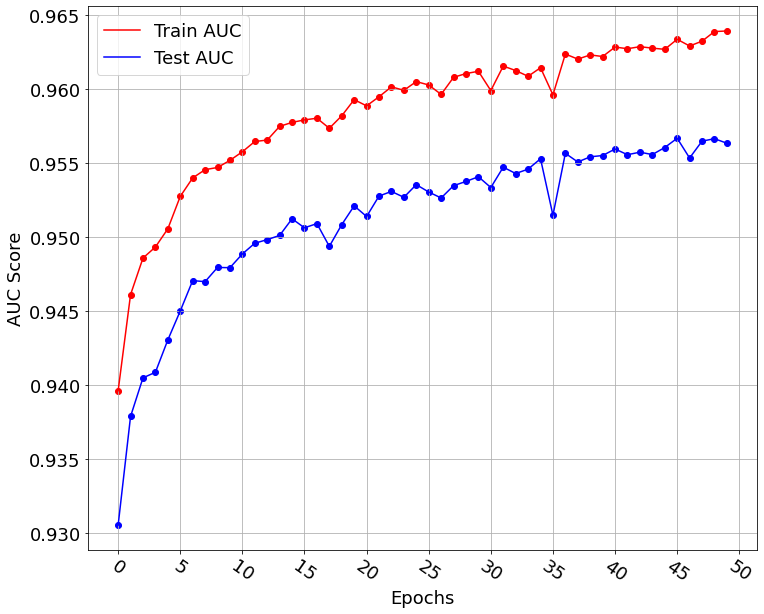

In [46]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,10))
plt.plot(np.arange(len(auc)),auc,color="red")
plt.plot(np.arange(len(auc)),val_auc,color='blue')
plt.scatter(np.arange(len(auc)),auc,color='red')
plt.scatter(np.arange(len(auc)),val_auc,color='blue')
plt.xticks(np.arange(0,len(auc)+1,5),rotation=-35)
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend(['Train AUC','Test AUC'])
plt.grid()
plt.show()

# We have achieved 95%+ AUC without overfitting model